In [54]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
base_dir = '/home/tun62034/fuadhassan/nfl-data-bowl/'
data_dir = os.path.join(base_dir, 'Sample_Data/Processed')
sys.path.append(base_dir)
sys.path.append(data_dir)

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [78]:
def load_data(data_dir):
    vls = pd.read_csv(os.path.join(data_dir, 'velocity_late_shifts.csv'))
    omp = pd.read_csv(os.path.join(data_dir, 'offensive_motion_plays.csv'))
    pts = pd.read_csv(os.path.join(data_dir, 'players_through_snap.csv'))
    target = pd.read_csv(os.path.join(data_dir, 'TargetValueConfusedPlays.csv'))
    
    return vls, omp,pts, target

vls, omp, pts, target = load_data(data_dir)
merged_df = omp.copy()
merged_df = merged_df.merge(target, on=['gameId', 'playId'], how='left')
merged_df = merged_df.merge(vls, on=['gameId', 'playId'], how='left')
merged_df = merged_df.merge(pts, on=['gameId', 'playId'], how='left')
merged_df = merged_df.fillna(0)
df = merged_df.copy()

In [79]:
vls.shape, omp.shape, pts.shape, target.shape

((12814, 5), (16124, 10), (3850, 6), (16124, 3))

In [80]:
X = df.drop(['gameId','playId','isConfused'], axis=1)
y = df['isConfused']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12899, 15), (3225, 15), (12899,), (3225,))

In [82]:
# Create the model
clf = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)

# Train the model
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=4, random_state=42)

In [83]:
# Predict on test data
y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report (includes precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Confused', 'Normal','Confused']))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.44

Classification Report:
              precision    recall  f1-score   support

Not Confused       0.44      0.10      0.17      1083
      Normal       0.44      0.94      0.60      1404
    Confused       0.25      0.01      0.01       738

    accuracy                           0.44      3225
   macro avg       0.38      0.35      0.26      3225
weighted avg       0.40      0.44      0.32      3225


Confusion Matrix:
[[ 112  963    8]
 [  87 1313    4]
 [  57  677    4]]


# Radmon Forest

In [84]:
# Create the Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=100,    # Number of trees
    max_depth=5,         # Limit tree depth
    random_state=42
)

# Fit on training data
rf_clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, random_state=42)

In [85]:
# Make predictions
y_pred_rf = rf_clf.predict(X_test)

Random Forest Accuracy: 0.44

Confusion Matrix:
 [[  61 1011   11]
 [  44 1352    8]
 [  30  702    6]]

Classification Report:
               precision    recall  f1-score   support

Not Confused       0.45      0.06      0.10      1083
      Normal       0.44      0.96      0.61      1404
    Confused       0.24      0.01      0.02       738

    accuracy                           0.44      3225
   macro avg       0.38      0.34      0.24      3225
weighted avg       0.40      0.44      0.30      3225



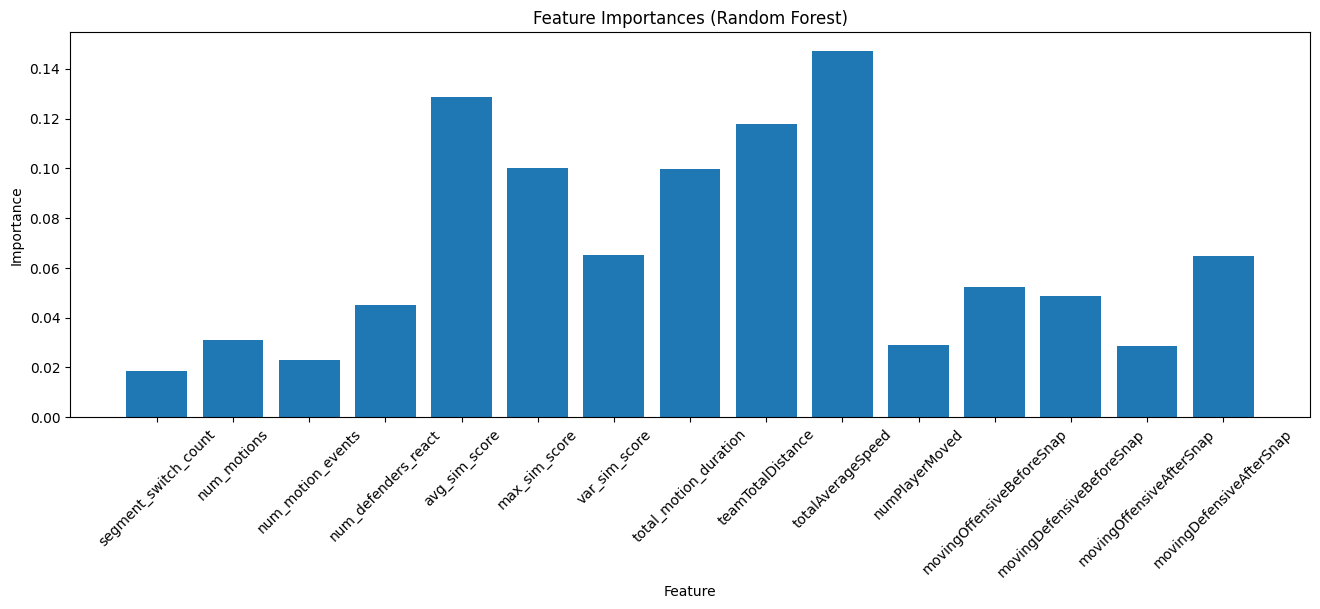

In [86]:
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=['Not Confused', 'Normal', 'Confused']))

# Feature importance
importances = rf_clf.feature_importances_
features = X.columns  # Assuming X is a pandas DataFrame
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(16, 5))
plt.bar(features, importances)
plt.title("Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45)  # Rotate feature labels by 45 degrees
plt.show()
